In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('btc_1h.csv')

In [ ]:
df.head()

datetime      open      high       low     close      volume
0  2018-01-01 05:30:00  13715.65  13715.65  13400.01  13529.01  443.356199
1  2018-01-01 06:30:00  13528.99  13595.89  13155.38  13203.06  383.697006
2  2018-01-01 07:30:00  13203.00  13418.43  13200.00  13330.18  429.064572
3  2018-01-01 08:30:00  13330.26  13611.27  13290.00  13410.03  420.087030
4  2018-01-01 09:30:00  13434.98  13623.29  13322.15  13601.01  340.807329

In [ ]:
df_lstm = df.drop(columns='datetime')

In [ ]:
df_lstm.head()

open      high       low     close      volume
0  13715.65  13715.65  13400.01  13529.01  443.356199
1  13528.99  13595.89  13155.38  13203.06  383.697006
2  13203.00  13418.43  13200.00  13330.18  429.064572
3  13330.26  13611.27  13290.00  13410.03  420.087030
4  13434.98  13623.29  13322.15  13601.01  340.807329

In [ ]:
df = df.dropna()

In [ ]:
df.set_index('datetime',inplace=True)

In [ ]:
df.isnull().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

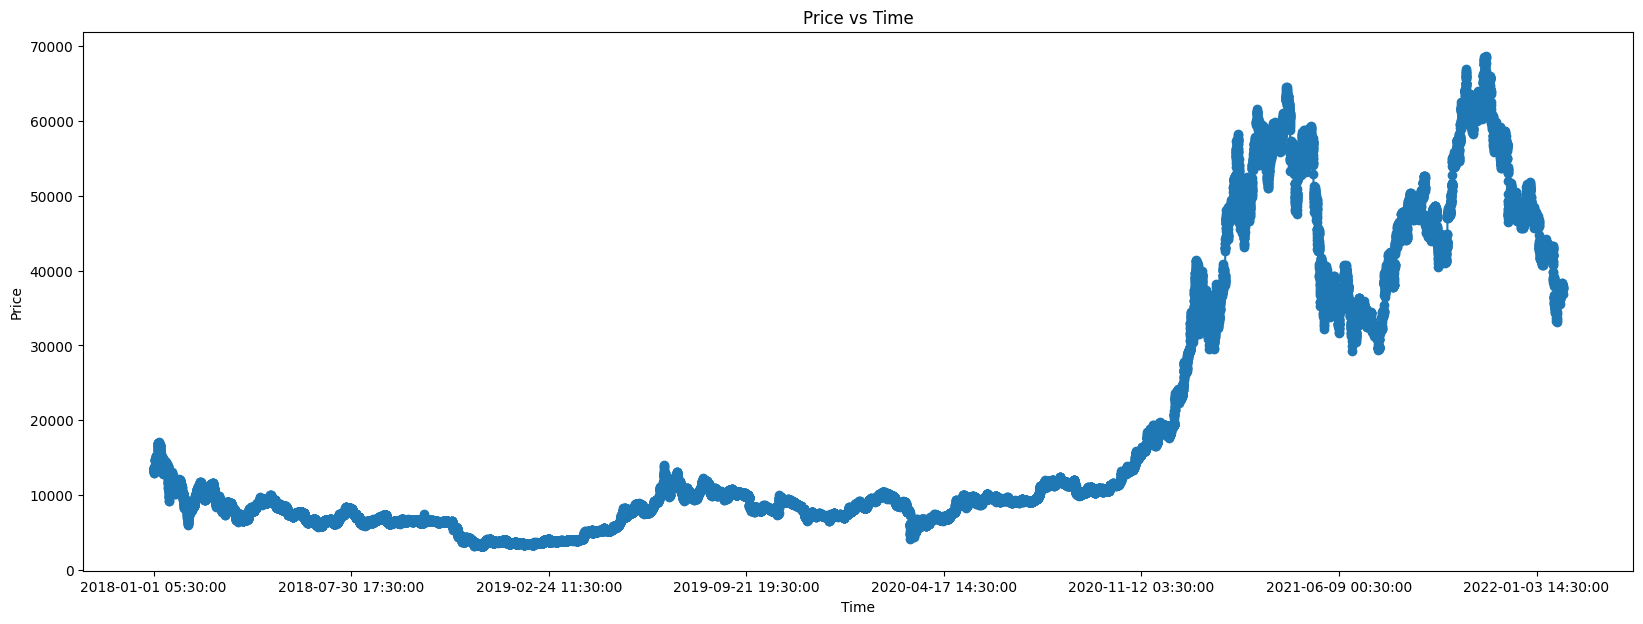

In [ ]:
df['close'].plot(title='Price vs Time', xlabel='Time', ylabel='Price', marker='o', linestyle='-',figsize=(20,7))
plt.show()

In [ ]:
df.skew()

open      1.220629
high      1.217938
low       1.223607
close     1.220500
volume    4.560364
dtype: float64

In [ ]:
df1 = df[['open','close','high','low']]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df_updated = scaler.fit_transform(np.array(df['close']).reshape(-1,1))
# df['open']=scaler.fit_transform(np.array(df['open']).reshape(-1,1))
# df['close']=scaler.fit_transform(np.array(df['close']).reshape(-1,1))
# df['high']=scaler.fit_transform(np.array(df['high']).reshape(-1,1))
# df['low']=scaler.fit_transform(np.array(df['low']).reshape(-1,1))

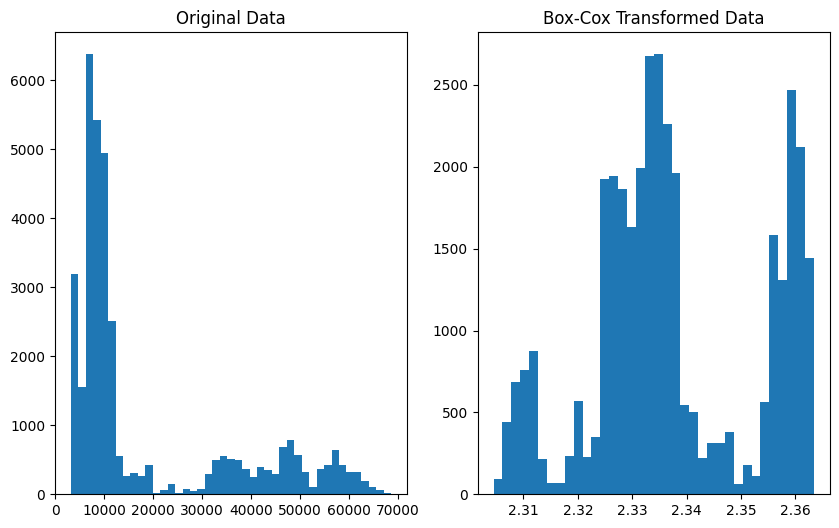

In [ ]:
import numpy as np
from scipy.stats import boxcox
import matplotlib.pyplot as plt

# Assuming 'data' is your dataset
transformed_data, lambda_value = boxcox(df['close'])

# Plot original and transformed data
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.hist(df['close'], bins='auto')
plt.title('Original Data')

plt.subplot(1, 2, 2)
plt.hist(transformed_data, bins='auto')
plt.title('Box-Cox Transformed Data')

plt.show()

In [ ]:
import seaborn as sns

<Axes: ylabel='Density'>

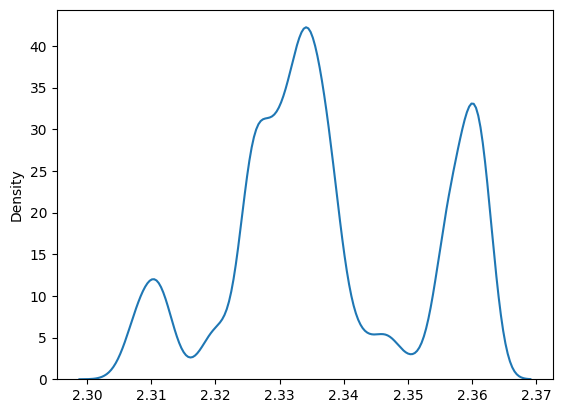

In [ ]:
sns.kdeplot(transformed_data)

In [ ]:
df_updated = pd.DataFrame({'close':transformed_data})

In [ ]:
df_updated.head()

close
0  2.341536
1  2.341081
2  2.341260
3  2.341372
4  2.341634

In [ ]:
df_updated['high'] = transformed_data

In [ ]:
df_updated['low'] = transformed_data

In [ ]:
df_updated['volume'] = transformed_data

In [ ]:
df_updated['open'] = transformed_data

In [ ]:
df_updated.skew()

close     0.120915
high      0.120915
low       0.120915
volume    0.120915
open      0.120915
dtype: float64

In [ ]:
transformed_data, lambda_value = boxcox(df['close'])

In [ ]:
transformed_data, lambda_value = boxcox(df['open'])

In [ ]:
transformed_data, lambda_value = boxcox(df['high'])

In [ ]:
transformed_data, lambda_value = boxcox(df['low'])

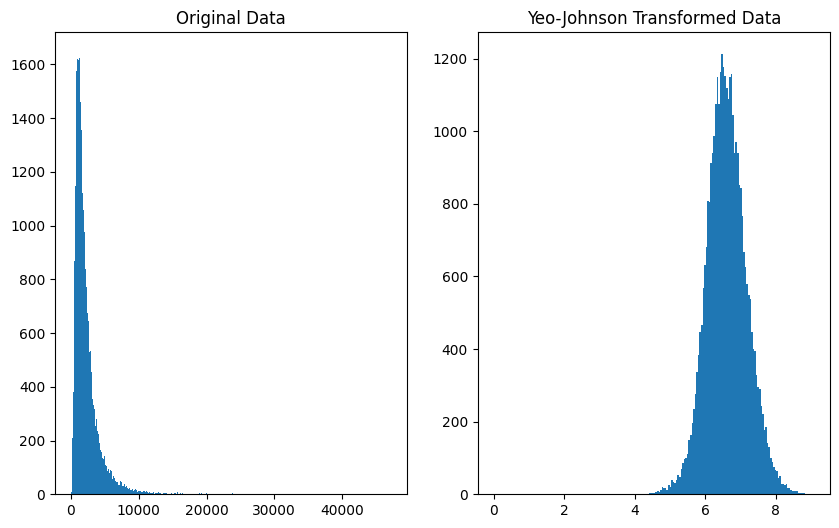

In [ ]:
import numpy as np
from scipy.stats import yeojohnson
import matplotlib.pyplot as plt

# Assuming 'data' is your dataset
transformed_data, lambda_value = yeojohnson(df['volume'])

# Plot original and transformed data
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.hist(df['volume'], bins='auto')
plt.title('Original Data')

plt.subplot(1, 2, 2)
plt.hist(transformed_data, bins='auto')
plt.title('Yeo-Johnson Transformed Data')

plt.show()

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
df_updated.head()

open      high       low     close
0  0.161054  0.158214  0.160007  0.156884
1  0.158203  0.153235  0.158187  0.153138
2  0.153223  0.155177  0.155491  0.153821
3  0.155167  0.156397  0.158421  0.155199
4  0.156767  0.159314  0.158604  0.155692

In [ ]:
columns=['close']
df_updated = pd.DataFrame(df_updated,columns=columns)

In [ ]:
df_updated.shape

(35664, 1)

In [ ]:
df_updated.head()

close
0  0.158214
1  0.153235
2  0.155177
3  0.156397
4  0.159314

**STACKED LSTM**

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Function to prepare the dataset for LSTM
def prepare_data(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:(i + time_steps)].values)
        y.append(data.iloc[i + time_steps].values)
    return np.array(X), np.array(y)

# Set the number of time steps
time_steps = 100  # You can adjust this based on your dataset

# Prepare the dataset
X, y = prepare_data(df_updated, time_steps)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the stacked LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=df_updated.shape[1]))  # Output layer with the same number of features

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

# Train the model with validation data
history = model.fit(X_train, y_train, epochs=10, batch_size=40, validation_data=(X_val, y_val))

# Now, you can use the trained model for predictions
# Adjust this part based on your use case
# For example, if you want to predict the next time step:
new_data = df_updated[-time_steps:].values.reshape(1, time_steps, df_updated.shape[1])
prediction = model.predict(new_data)

print("Predicted values:", prediction)

Epoch 1/10
712/712 [==============================] - 17s 16ms/step - loss: 0.0091 - val_loss: 0.0080
Epoch 2/10
712/712 [==============================] - 11s 15ms/step - loss: 0.0054 - val_loss: 0.0095
Epoch 3/10
712/712 [==============================] - 11s 16ms/step - loss: 0.0047 - val_loss: 0.0043
Epoch 4/10
712/712 [==============================] - 11s 16ms/step - loss: 0.0041 - val_loss: 0.0059
Epoch 5/10
712/712 [==============================] - 13s 18ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 6/10
712/712 [==============================] - 11s 16ms/step - loss: 0.0034 - val_loss: 0.0057
Epoch 7/10
712/712 [==============================] - 11s 16ms/step - loss: 0.0032 - val_loss: 0.0027
Epoch 8/10
712/712 [==============================] - 11s 15ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 9/10
712/712 [==============================] - 11s 15ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 10/10
1/1 [==============================] - 1s 1s/step
Predicted values: [[

In [ ]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_val)

223/223 [==============================] - 1s 6ms/step


In [ ]:
import numpy

In [ ]:
len(train_predict)

28451

In [ ]:
test_predict

array([[0.0610636 ],
       [0.00304858],
       [0.0037864 ],
       ...,
       [0.10724267],
       [0.49714106],
       [0.04312694]], dtype=float32)

In [ ]:
print("Shape of train_predict:", train_predict.shape)

Shape of train_predict: (28451, 5)


In [ ]:
train_predict1 = scaler.inverse_transform(train_predict)

In [ ]:
test_predict1 = scaler.inverse_transform(test_predict)

In [ ]:
len(df)

35664

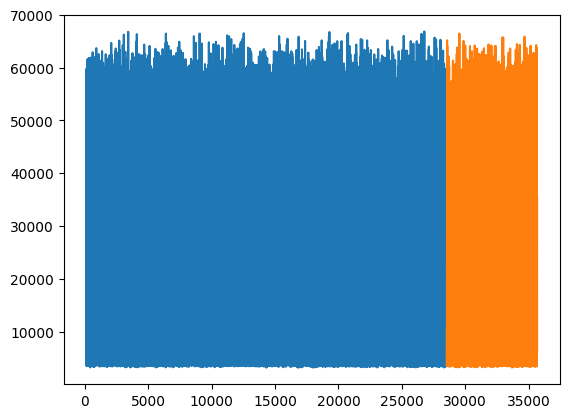

In [ ]:
look_back=100
trainPredictPlot = numpy.empty_like(df_updated)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict1)+look_back, :] = train_predict1
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df_updated)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict1)+(look_back*2)+1-102:len(df_updated)-1, :] = test_predict1
# plot baseline and predictions
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

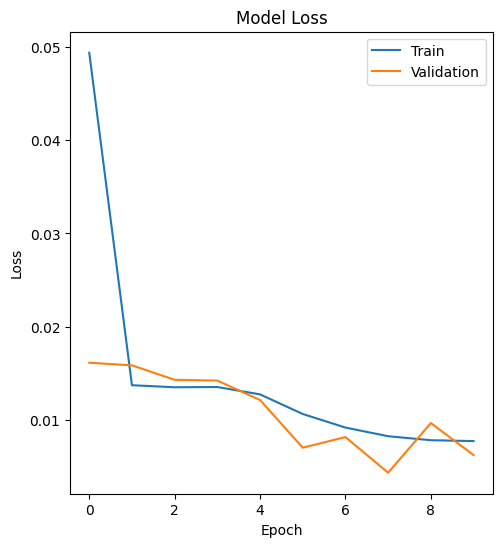

In [ ]:
# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

In [ ]:
!pip install shap
!pip install lime

import shap
import lime
import lime.lime_tabular

In [ ]:
print(X_train)


[[[2.33072136 2.33072136 2.33072136 2.33072136 2.33072136]
  [2.33060751 2.33060751 2.33060751 2.33060751 2.33060751]
  [2.33070399 2.33070399 2.33070399 2.33070399 2.33070399]
  ...
  [2.33123424 2.33123424 2.33123424 2.33123424 2.33123424]
  [2.33118672 2.33118672 2.33118672 2.33118672 2.33118672]
  [2.3311432  2.3311432  2.3311432  2.3311432  2.3311432 ]]

 [[2.33567382 2.33567382 2.33567382 2.33567382 2.33567382]
  [2.33544139 2.33544139 2.33544139 2.33544139 2.33544139]
  [2.33562208 2.33562208 2.33562208 2.33562208 2.33562208]
  ...
  [2.33874224 2.33874224 2.33874224 2.33874224 2.33874224]
  [2.33870333 2.33870333 2.33870333 2.33870333 2.33870333]
  [2.33879772 2.33879772 2.33879772 2.33879772 2.33879772]]

 [[2.32871218 2.32871218 2.32871218 2.32871218 2.32871218]
  [2.328699   2.328699   2.328699   2.328699   2.328699  ]
  [2.32872805 2.32872805 2.32872805 2.32872805 2.32872805]
  ...
  [2.3252394  2.3252394  2.3252394  2.3252394  2.3252394 ]
  [2.32533968 2.32533968 2.3253396

In [ ]:
explainer = lime.lime_tabular.RecurrentTabularExplainer(X_train, training_labels=y_train, feature_names=df['close'],
                                                   discretize_continuous=True,
                                                   class_names=['Not Profitable', 'Profitable'],
                                                   discretizer='decile')

In [ ]:
instance_index = 0  # Replace with desired index
exp = explainer.explain_instance(X_val[instance_index, :], model.predict, num_features=100)
exp.show_in_notebook()


157/157 [==============================] - 2s 10ms/step



                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    


In [ ]:
df_updated[-time_steps:]

close      high       low    volume      open
35564  2.356539  2.356539  2.356539  2.356539  2.356539
35565  2.356602  2.356602  2.356602  2.356602  2.356602
35566  2.356702  2.356702  2.356702  2.356702  2.356702
35567  2.356766  2.356766  2.356766  2.356766  2.356766
35568  2.356389  2.356389  2.356389  2.356389  2.356389
...         ...       ...       ...       ...       ...
35659  2.356987  2.356987  2.356987  2.356987  2.356987
35660  2.357001  2.357001  2.357001  2.357001  2.357001
35661  2.357019  2.357019  2.357019  2.357019  2.357019
35662  2.357050  2.357050  2.357050  2.357050  2.357050
35663  2.356708  2.356708  2.356708  2.356708  2.356708

[100 rows x 5 columns]

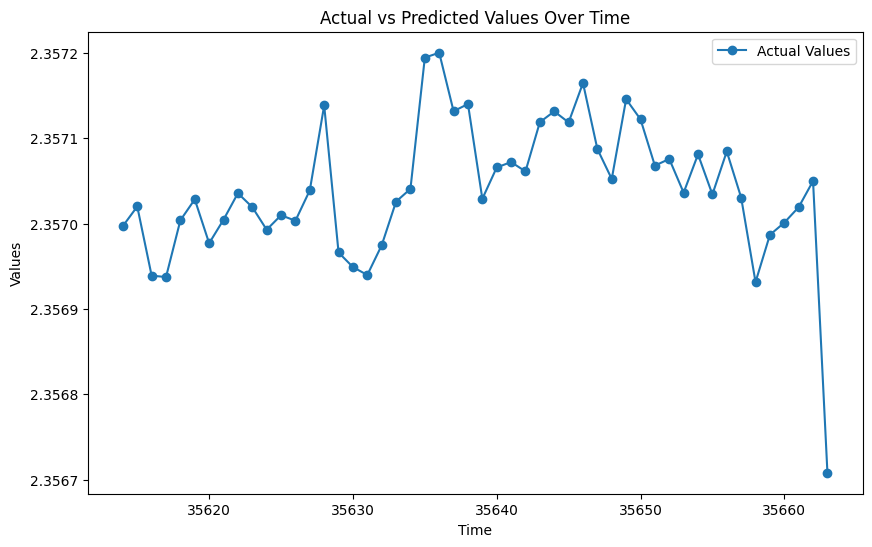

In [ ]:
time_index = df_updated.index[-500:]
plt.figure(figsize=(10, 6))
# plt.plot(time_index, df_updated.iloc[-time_steps:].values[][0], label='Actual Values', marker='o')
plt.plot(df_updated.index[-50:], df_updated['close'].values[df_updated.index[-50:]], label='Actual Values', marker='o')
# plt.plot(df_updated.index[-1:], prediction[0][0], label='Predicted Values', marker='o')
plt.title('Actual vs Predicted Values Over Time')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

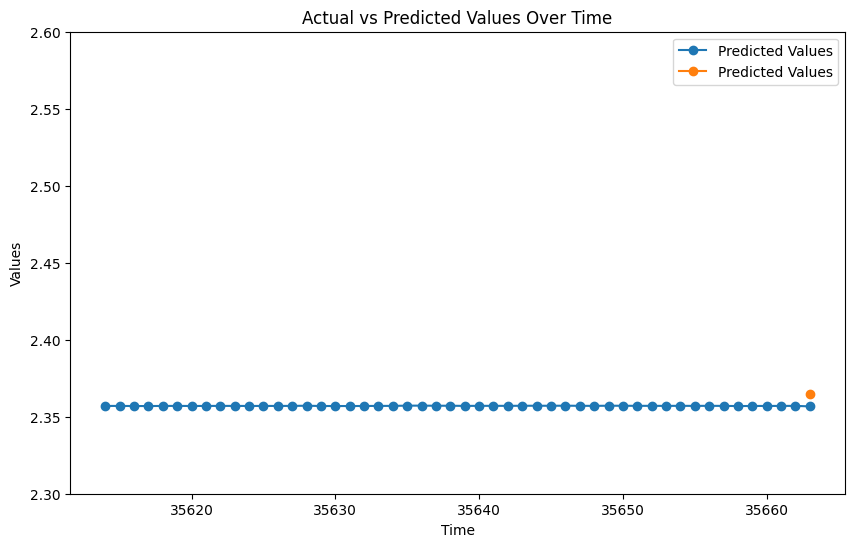

In [ ]:
import numpy as np

time_index = df_updated.index[-500:]

plt.figure(figsize=(10, 6))

# Set the desired y-axis tick values
desired_y_values = np.arange(2.3, 2.6, 0.05)

plt.plot(df_updated.index[-50:], df_updated['close'].values[df_updated.index[-50:]], label='Predicted Values', marker='o')
plt.plot(df_updated.index[-1:], prediction[0][0], label='Predicted Values', marker='o')

plt.title('Actual vs Predicted Values Over Time')
plt.xlabel('Time')
plt.ylabel('Values')

# Set y-axis tick values
plt.yticks(desired_y_values)

plt.legend()
plt.show()

**BIDIRECTIONAL LSTM**

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Function to prepare the dataset for Bidirectional LSTM
def prepare_data(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:(i + time_steps)].values)
        y.append(data.iloc[i + time_steps].values)
    return np.array(X), np.array(y)

# Set the number of time steps
time_steps = 100  # You can adjust this based on your dataset

# Prepare the dataset
X, y = prepare_data(df_updated, time_steps)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the Bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X.shape[1], X.shape[2])))
model.add(Bidirectional(LSTM(units=50)))
model.add(Dense(units=df_updated.shape[1]))  # Output layer with the same number of features

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

# Train the model with validation data
history = model.fit(X_train, y_train, epochs=10, batch_size=40, validation_data=(X_val, y_val))

# Now, you can use the trained model for predictions
# Adjust this part based on your use case
# For example, if you want to predict the next time step:
new_data = df_updated[-time_steps:].values.reshape(1, time_steps, df_updated.shape[1])
prediction = model.predict(new_data)

print("Predicted values:", prediction)


Epoch 1/10
712/712 [==============================] - 26s 26ms/step - loss: 0.0343 - val_loss: 0.0136
Epoch 2/10
712/712 [==============================] - 18s 25ms/step - loss: 0.0140 - val_loss: 0.0170
Epoch 3/10
712/712 [==============================] - 18s 25ms/step - loss: 0.0132 - val_loss: 0.0169
Epoch 4/10
712/712 [==============================] - 17s 24ms/step - loss: 0.0117 - val_loss: 0.0139
Epoch 5/10
712/712 [==============================] - 17s 23ms/step - loss: 0.0108 - val_loss: 0.0069
Epoch 6/10
712/712 [==============================] - 18s 25ms/step - loss: 0.0099 - val_loss: 0.0063
Epoch 7/10
712/712 [==============================] - 19s 26ms/step - loss: 0.0091 - val_loss: 0.0129
Epoch 8/10
712/712 [==============================] - 18s 25ms/step - loss: 0.0087 - val_loss: 0.0052
Epoch 9/10
712/712 [==============================] - 18s 25ms/step - loss: 0.0083 - val_loss: 0.0066
Epoch 10/10
1/1 [==============================] - 1s 1s/step
Predicted values: [[

In [ ]:
df_updated[-time_steps:]

close      high       low    volume      open
35564  2.356539  2.356539  2.356539  2.356539  2.356539
35565  2.356602  2.356602  2.356602  2.356602  2.356602
35566  2.356702  2.356702  2.356702  2.356702  2.356702
35567  2.356766  2.356766  2.356766  2.356766  2.356766
35568  2.356389  2.356389  2.356389  2.356389  2.356389
...         ...       ...       ...       ...       ...
35659  2.356987  2.356987  2.356987  2.356987  2.356987
35660  2.357001  2.357001  2.357001  2.357001  2.357001
35661  2.357019  2.357019  2.357019  2.357019  2.357019
35662  2.357050  2.357050  2.357050  2.357050  2.357050
35663  2.356708  2.356708  2.356708  2.356708  2.356708

[100 rows x 5 columns]

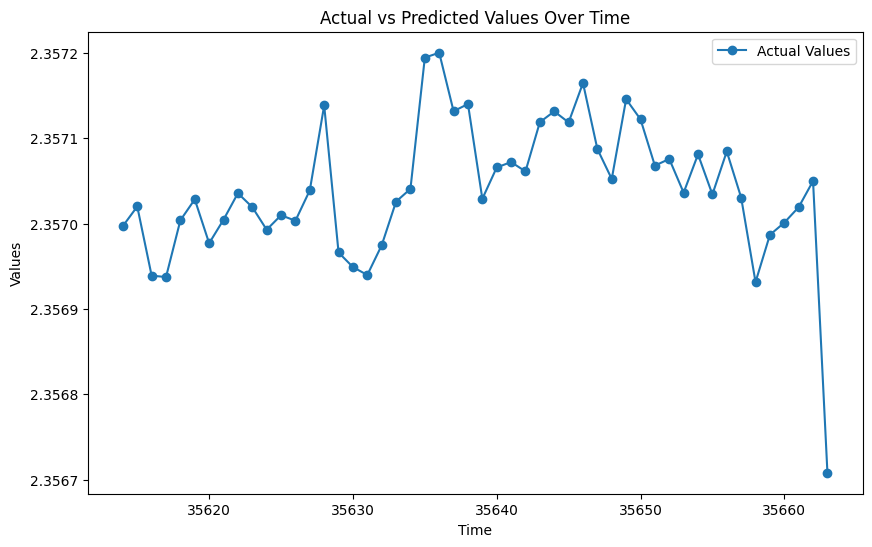

In [ ]:
time_index = df_updated.index[-500:]
plt.figure(figsize=(10, 6))
# plt.plot(time_index, df_updated.iloc[-time_steps:].values[][0], label='Actual Values', marker='o')
plt.plot(df_updated.index[-50:], df_updated['close'].values[df_updated.index[-50:]], label='Actual Values', marker='o')
# plt.plot(df_updated.index[-1:], prediction[0][0], label='Predicted Values', marker='o')
plt.title('Actual vs Predicted Values Over Time')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

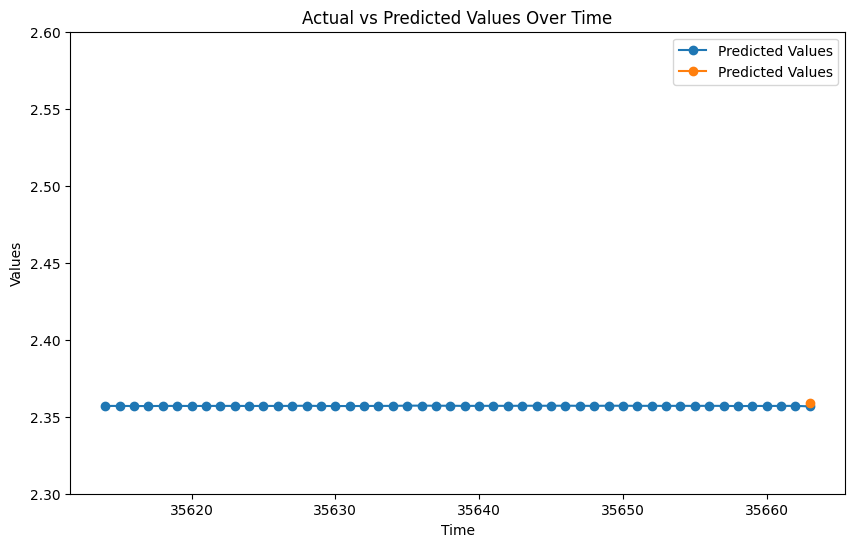

In [ ]:
import numpy as np

time_index = df_updated.index[-500:]

plt.figure(figsize=(10, 6))

# Set the desired y-axis tick values
desired_y_values = np.arange(2.3, 2.6, 0.05)

plt.plot(df_updated.index[-50:], df_updated['close'].values[df_updated.index[-50:]], label='Predicted Values', marker='o')
plt.plot(df_updated.index[-1:], prediction[0][0], label='Predicted Values', marker='o')

plt.title('Actual vs Predicted Values Over Time')
plt.xlabel('Time')
plt.ylabel('Values')

# Set y-axis tick values
plt.yticks(desired_y_values)

plt.legend()
plt.show()

**CONVOLUTIONAL LSTM**

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import ConvLSTM2D, Dense, Flatten
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Function to prepare the dataset for ConvLSTM
def prepare_data(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:(i + time_steps)].values.reshape((time_steps, 1, data.shape[1], 1)))
        y.append(data.iloc[i + time_steps].values)
    return np.array(X), np.array(y)

# Set the number of time steps
time_steps = 100  # You can adjust this based on your dataset

# Prepare the dataset
X, y = prepare_data(df_updated, time_steps)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the ConvLSTM model
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1, 2), activation='relu', input_shape=(time_steps, 1, df_updated.shape[1], 1)))
model.add(Flatten())
model.add(Dense(units=df_updated.shape[1]))  # Output layer with the same number of features

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

# Train the model with validation data
history = model.fit(X_train, y_train, epochs=10, batch_size=40, validation_data=(X_val, y_val))

# Now, you can use the trained model for predictions
# Adjust this part based on your use case
# For example, if you want to predict the next time step:
new_data = df_updated[-time_steps:].values.reshape((1, time_steps, 1, df_updated.shape[1], 1))
prediction = model.predict(new_data)

print("Predicted values:", prediction)


Epoch 1/10
712/712 [==============================] - 235s 327ms/step - loss: 0.4014 - val_loss: 0.0033
Epoch 2/10
712/712 [==============================] - 233s 327ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 3/10
712/712 [==============================] - 236s 331ms/step - loss: 0.0031 - val_loss: 0.0043
Epoch 4/10
712/712 [==============================] - 241s 339ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 5/10
712/712 [==============================] - 230s 324ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 6/10
712/712 [==============================] - 231s 324ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 7/10
712/712 [==============================] - 229s 322ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 8/10
712/712 [==============================] - 231s 324ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 9/10
712/712 [==============================] - 233s 327ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 10/10
1/1 [==============================] - 0s 246ms/step

In [ ]:
!pip install tensorflow